## enter model path

In [1]:
path = '../log/nbody/version_1/checkpoints/best_model_valid-epoch=217.ckpt'

In [4]:
from pytorch_lightning.utilities.model_summary import ModelSummary
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import torch
import sys
sys.path.append('../')

from utils.visualize import plot_traj_step_3d
from data.nbody import NBodyDataset
from data.boids import BoidsDataset
from models import SimulatorEGNCA


device = 'cuda'

model = SimulatorEGNCA.load_from_checkpoint(path).to(device)
dataset = BoidsDataset('../data/boids/') if model.args.dataset == 'boids' else NBodyDataset('../data/nbody/')
num_nodes = dataset.coord_dataset.size(2)

print(ModelSummary(model, max_depth=1))

  | Name          | Type    | Params
------------------------------------------
0 | vel2node_feat | Linear  | 32    
1 | egnn          | EGNN    | 5.5 K 
2 | criterion     | MSELoss | 0     
------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


## Animation

In [8]:
n_steps = 100
coord_traj_true, vel_traj_true = dataset.simulator.sample_trajectory(n_steps, num_nodes, to_torch=True)
# coord_traj_true, vel_traj_true = coord_traj_true[100:], vel_traj_true[100:]
with torch.no_grad():
    coord_traj_pred, vel_traj_pred = model(
        coord_traj_true[0].to(device), vel_traj_true[0].to(device), len(coord_traj_true)-1)

<IPython.core.display.Javascript object>


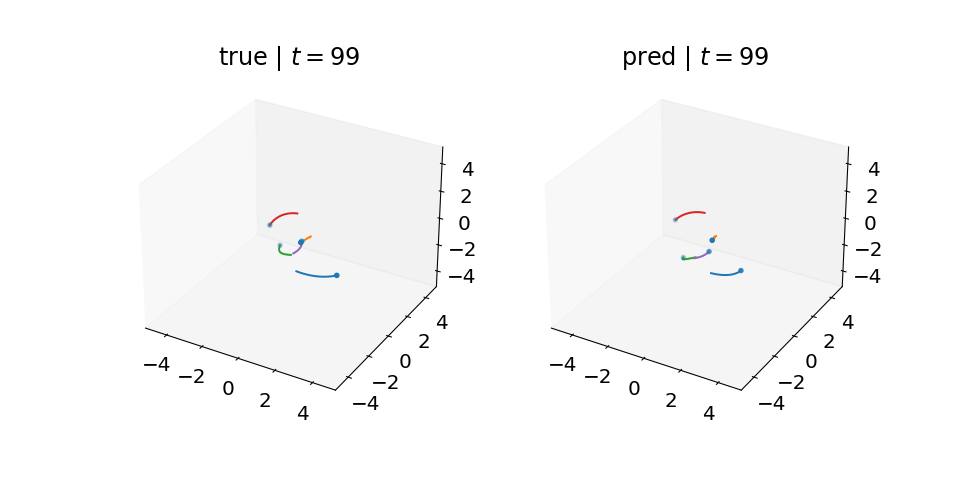

In [9]:
def animate(t):
    ax1.clear()
    plot_traj_step_3d(coord_traj_true, t, tail_len=10, box_dim=5, title='true | $t=%d$' % t, ax=ax1)
    # plot_traj_step_3d(coord_traj_true, t, box_dim=25, title='true | $t=%d$' % t, ax=ax1)
    ax2.clear()
    plot_traj_step_3d(coord_traj_pred, t, tail_len=10, box_dim=5, title='pred | $t=%d$' % t, ax=ax2)
    # plot_traj_step_3d(coord_traj_pred, t, box_dim=25, title='pred | $t=%d$' % t, ax=ax2)

fig = plt.figure(figsize=(10, 5), dpi=80)
fig.tight_layout()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ani = animation.FuncAnimation(fig, animate, frames=range(300), interval=25, repeat=False)
# ani.save('evolve.gif', dpi=300, writer=animation.PillowWriter(fps=2))

## SampEn & CorrDim

In [10]:
import nolds

def avg_measure(trajectory, measure_fn, **kwargs):
    measures = []
    for i in np.random.permutation(trajectory.shape[1]):
        measures.append(measure_fn(trajectory[:, i], **kwargs))
    mu, std = np.mean(measures), np.std(measures)
    print(f"{measure_fn.__name__} {mu} +- {std}")
    return np.array(measures)

In [11]:
n_steps = 500
coord_traj_true, vel_traj_true = dataset.simulator.sample_trajectory(n_steps, num_nodes, to_torch=True)
with torch.no_grad():
    coord_traj_pred, vel_traj_pred = model(
        coord_traj_true[0].to(device), vel_traj_true[0].to(device), len(coord_traj_true)-1)
    
full_traj_true = torch.cat([coord_traj_true, vel_traj_true], -1)
full_traj_pred = torch.cat([coord_traj_pred, vel_traj_pred], -1)

avg_measure(full_traj_true.cpu().numpy(), nolds.sampen);
avg_measure(full_traj_pred.cpu().numpy(), nolds.sampen);

avg_measure(full_traj_true.cpu().numpy(), nolds.corr_dim, emb_dim=10);
avg_measure(full_traj_pred.cpu().numpy(), nolds.corr_dim, emb_dim=10);

sampen 0.1695721971875615 +- 0.005902392358024998
sampen 0.13538368743012943 +- 0.02045826561549081
corr_dim 1.9147841110502604 +- 0.03104321747762702
corr_dim 1.871702060739129 +- 0.04388716967614557
